### 数据解压命令 shell 脚本 unzip_data.sh
```bash
# unzip_data.sh 内容 数据压缩文件所在目录为 data_weather， 解压目录为 weather
unzip -q data_weather/weather_round1_train_2007.zip -d weather
unzip -q data_weather/weather_round1_train_2008.zip -d weather
unzip -q data_weather/weather_round1_train_2009.zip -d weather
unzip -q data_weather/weather_round1_train_2010.zip -d weather
unzip -q data_weather/weather_round1_train_2011.zip -d weather
unzip -q data_weather/weather_round1_test.zip -d weather
```

### 安装所需依赖 并创建所需目录 shell 脚本 depes_install.sh
```bash
# depes_install.sh 内容
pip install -q importlib-metadata==4.13.0
pip install -q zarr lightgbm catboost
pip install -q xarray[complete]
mkdir model output
```

In [ ]:
# 若未进行数据解压和依赖的安装,执行上述两个脚本
! bash ./unzip_data.sh
! bash ./depes_install.sh

### 数据载入与特点分析

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

import torch
torch.random.seed()
np.random.seed(0)

### 训练数据

In [44]:
path = 'weather'
# 如果不是 dask array，按时刻进行分块转换为 dask array
def chunk_time(ds):
    dims = {k:v for k,v in ds.dims.items()}
    dims['time'] = 1
    ds = ds.chunk(dims)
    return ds
# 数据载入
def load_dataset():
    ds = []
    for y in range(2007, 2012):
        data_name = os.path.join(path, f'weather_round1_train_{y}')
        x = xr.open_zarr(data_name, consolidated=True)
        print(f'{data_name}, {x.time.values[0]} ~ {x.time.values[-1]}')
        ds.append(x)
    ds = xr.concat(ds, 'time')
    ds = chunk_time(ds)
    return ds

ds = load_dataset().x # 载入的数据集中含有其他信息，x是 array 形式的数据

weather/weather_round1_train_2007, 2007-01-01T00:00:00.000000000 ~ 2007-12-31T18:00:00.000000000
weather/weather_round1_train_2008, 2008-01-01T00:00:00.000000000 ~ 2008-12-31T18:00:00.000000000
weather/weather_round1_train_2009, 2009-01-01T00:00:00.000000000 ~ 2009-12-31T18:00:00.000000000
weather/weather_round1_train_2010, 2010-01-01T00:00:00.000000000 ~ 2010-12-31T18:00:00.000000000
weather/weather_round1_train_2011, 2011-01-01T00:00:00.000000000 ~ 2011-12-31T18:00:00.000000000


In [48]:
len(ds),ds.shape,ds.dims

(7304, (7304, 70, 161, 161), ('time', 'channel', 'lat', 'lon'))

### 数据维度
数据 array 是四维的 array：time × channel × lat × lon。
数据按照时刻 time 进行分块意味着 每个 time 对应一个样本，channel 是一个经纬度坐标的天气数值特征，lat × lon 是精度和维度空间网格。channel 数量一共70，前65个作为输入的特征，后5个是需要预测的输出特征。

### 数据划分
取最后 5 天数据作为测试数据（采样时每6小时采样，对应一个时刻），对应 20 个 样本。

In [77]:
shape = ds.shape # dim: time x channel x lat x lon 
times = ds.time.values # times
features = list(ds.channel.values) # features: 65(input) + 5(output) on a coordinate

num_step = 20 # 取最后5天数据进行测试
hist_times = times[slice(0, -num_step)] 

print(f'data array shape: {shape}')
print(f'history times : predict times = {len(hist_times)} : {num_step}\n')
print(f'all times: {times[0]} ~ {times[-1]}')
print(f'history times: {hist_times[0]} ~ {hist_times[-1]}')
print(f'predict times: {times[-20]} ~ {times[-1]}\n')
print(f'input features: {features[:-5]}\n')
print(f'output features: {output_features[-5:]}')

data array shape: (7304, 70, 161, 161)
history times : predict times = 7284 : 20

all times: 2007-01-01T00:00:00.000000000 ~ 2011-12-31T18:00:00.000000000
history times: 2007-01-01T00:00:00.000000000 ~ 2011-12-26T18:00:00.000000000
predict times: 2011-12-27T00:00:00.000000000 ~ 2011-12-31T18:00:00.000000000

input features: ['z50', 'z100', 'z150', 'z200', 'z250', 'z300', 'z400', 'z500', 'z600', 'z700', 'z850', 'z925', 'z1000', 't50', 't100', 't150', 't200', 't250', 't300', 't400', 't500', 't600', 't700', 't850', 't925', 't1000', 'u50', 'u100', 'u150', 'u200', 'u250', 'u300', 'u400', 'u500', 'u600', 'u700', 'u850', 'u925', 'u1000', 'v50', 'v100', 'v150', 'v200', 'v250', 'v300', 'v400', 'v500', 'v600', 'v700', 'v850', 'v925', 'v1000', 'r50', 'r100', 'r150', 'r200', 'r250', 'r300', 'r400', 'r500', 'r600', 'r700', 'r850', 'r925', 'r1000']

output features: ['t2m', 'u10', 'v10', 'msl', 'tp']


In [73]:
ds

<xarray.DataArray 'x' (time: 7304, channel: 70, lat: 161, lon: 161)>
dask.array<concatenate, shape=(7304, 70, 161, 161), dtype=float32, chunksize=(1, 70, 161, 161), chunktype=numpy.ndarray>
Coordinates:
  * channel  (channel) <U5 'z50' 'z100' 'z150' 'z200' ... 'u10' 'v10' 'msl' 'tp'
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 10.75 10.5 10.25 10.0
  * lon      (lon) float32 100.0 100.2 100.5 100.8 ... 139.2 139.5 139.8 140.0
  * time     (time) datetime64[ns] 2007-01-01 ... 2011-12-31T18:00:00

### 测试数据

比赛所使用的测试数据文件共300个，从 000.pt ~ 299.pt 。每个测试文件仅给出两个时刻的气候数据，需要据此预测后面20个时刻的气候数据。

In [80]:
file_lists = os.listdir(f'{path}/weather_round1_test/input')
print(file_lists)

['195.pt', '221.pt', '210.pt', '087.pt', '186.pt', '100.pt', '079.pt', '073.pt', '070.pt', '078.pt', '290.pt', '063.pt', '046.pt', '189.pt', '160.pt', '159.pt', '259.pt', '167.pt', '099.pt', '271.pt', '022.pt', '012.pt', '090.pt', '224.pt', '249.pt', '064.pt', '122.pt', '208.pt', '219.pt', '200.pt', '084.pt', '244.pt', '011.pt', '028.pt', '242.pt', '190.pt', '018.pt', '077.pt', '132.pt', '222.pt', '254.pt', '098.pt', '226.pt', '273.pt', '267.pt', '166.pt', '227.pt', '294.pt', '255.pt', '183.pt', '274.pt', '241.pt', '136.pt', '211.pt', '093.pt', '097.pt', '220.pt', '169.pt', '027.pt', '047.pt', '172.pt', '232.pt', '118.pt', '008.pt', '041.pt', '023.pt', '282.pt', '165.pt', '123.pt', '240.pt', '020.pt', '144.pt', '234.pt', '092.pt', '112.pt', '147.pt', '129.pt', '086.pt', '170.pt', '179.pt', '198.pt', '296.pt', '066.pt', '052.pt', '115.pt', '049.pt', '091.pt', '072.pt', '157.pt', '246.pt', '043.pt', '182.pt', '193.pt', '007.pt', '096.pt', '181.pt', '032.pt', '124.pt', '039.pt', '109.pt',

In [82]:
input_data = torch.load(f'{path}/weather_round1_test/input/{file_lists[0]}')
input_data.shape # 一个测试数据文件给出的气候数据

torch.Size([2, 70, 161, 161])

### 统计方法 Baseline
统计学方法 baseline 给出的方法是 历史均值统计策略。该方法使用给出的两个时刻的气候数据的每个坐标上的预测特征 取均值作为后20个时刻的预测特征值。未使用训练数据。

In [93]:
for file in file_lists:
    input_data = torch.load(f'{data_dir}/weather_round1_test/input/{file}') # 载入测试数据
    m = torch.mean(input_data, axis=0)[-5:,:,:] # 5个预测特征在每个坐标上的均值
    output_data = torch.tile(m, (20,1,1,1)) # 重复20次作为后20个时刻的预测值
    torch.save(output_data.half(), f'output/{file}', ) # 根据比赛要求数据保存时使用 float16，即半精度进行保存

In [90]:
import zipfile,os
path='./output/' # 测试文件预测输出数据保存目录
zipName = 'output.zip' # 预测数据压缩文件名称
i = 0
s = len(os.listdir(path))
f = zipfile.ZipFile(zipName,'w',zipfile.ZIP_DEFLATED)
for dirpath, dirnames, filenames in os.walk(path):
    for filename in filenames:
        f.write(os.path.join(dirpath,filename)) # 将每个预测输出数据文件添加至压缩文件
        i += 1
        print(f'{filename} is zipped. {i:03}/{s:03}',end='\r')
f.close()

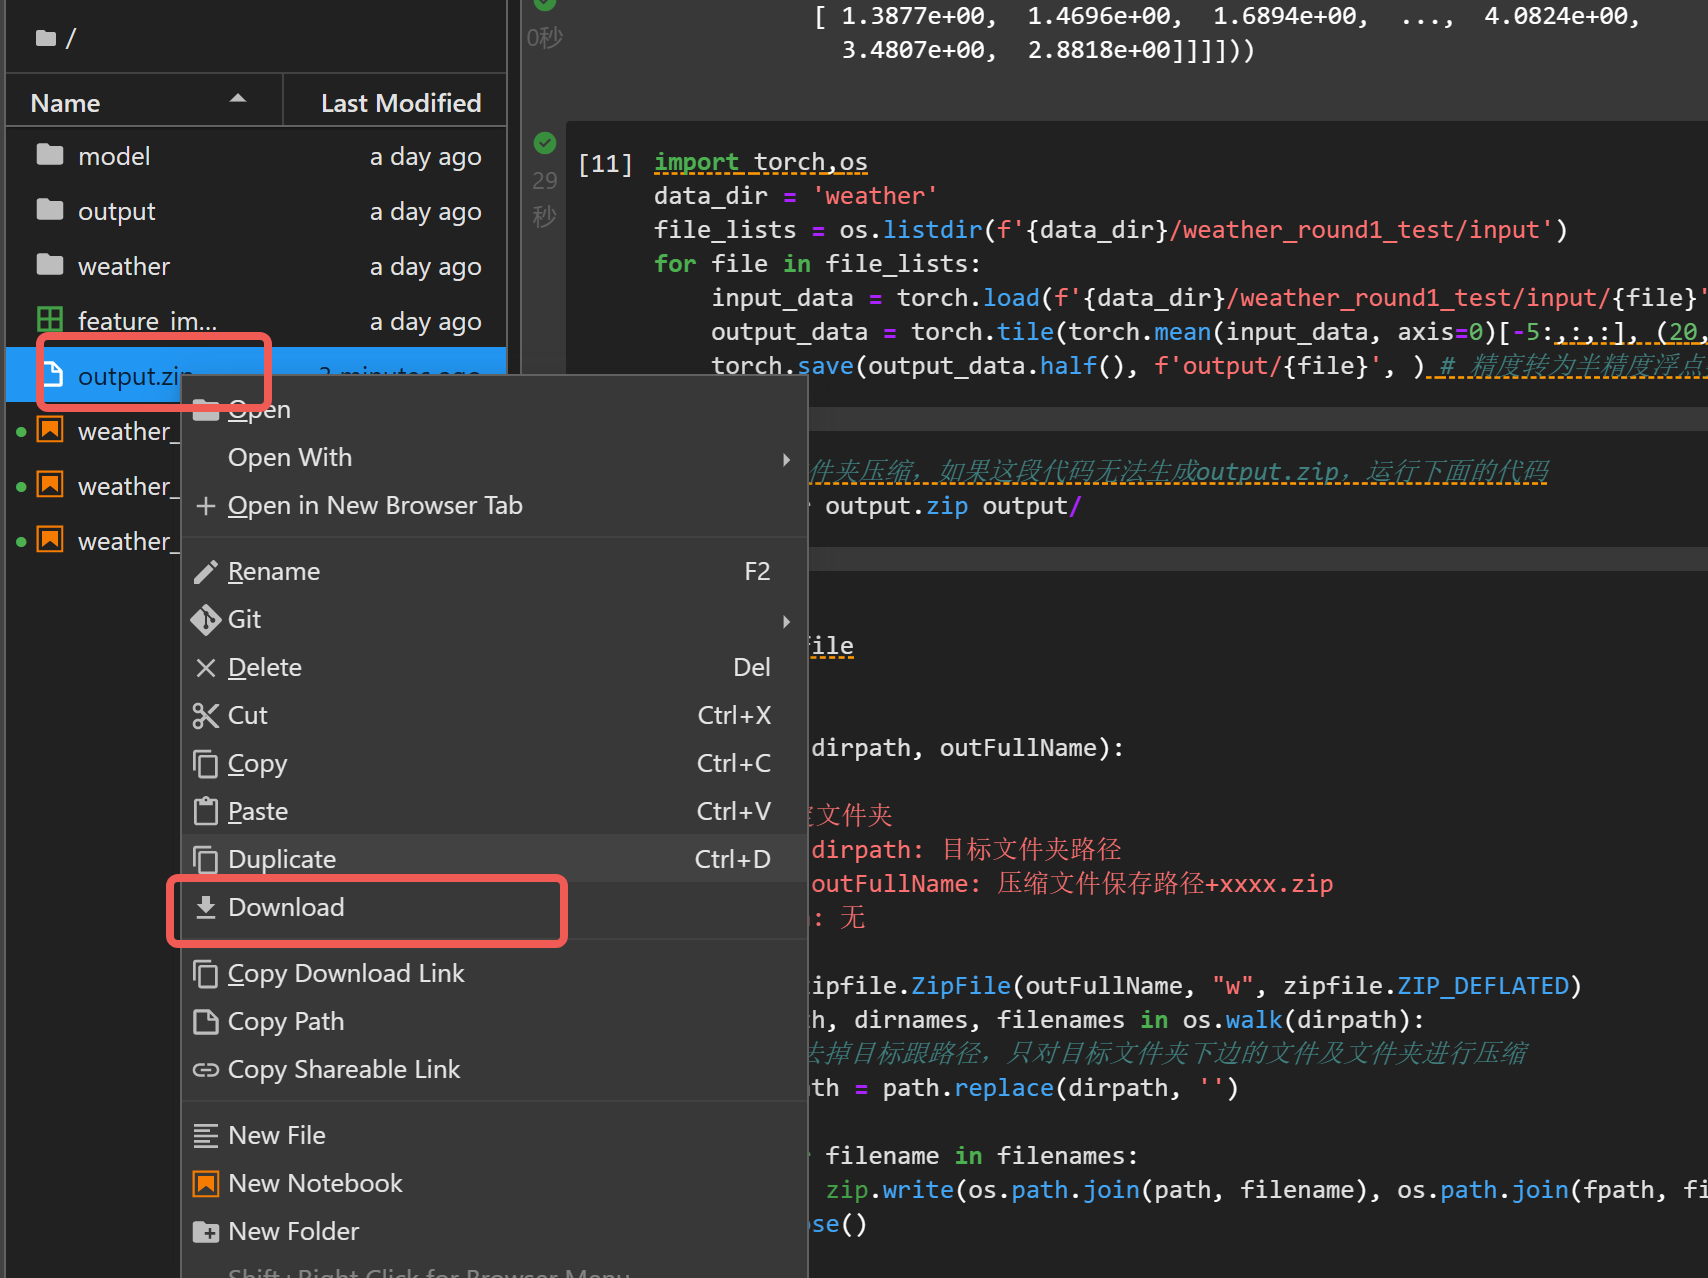# 获得成绩
## 下载结果文件
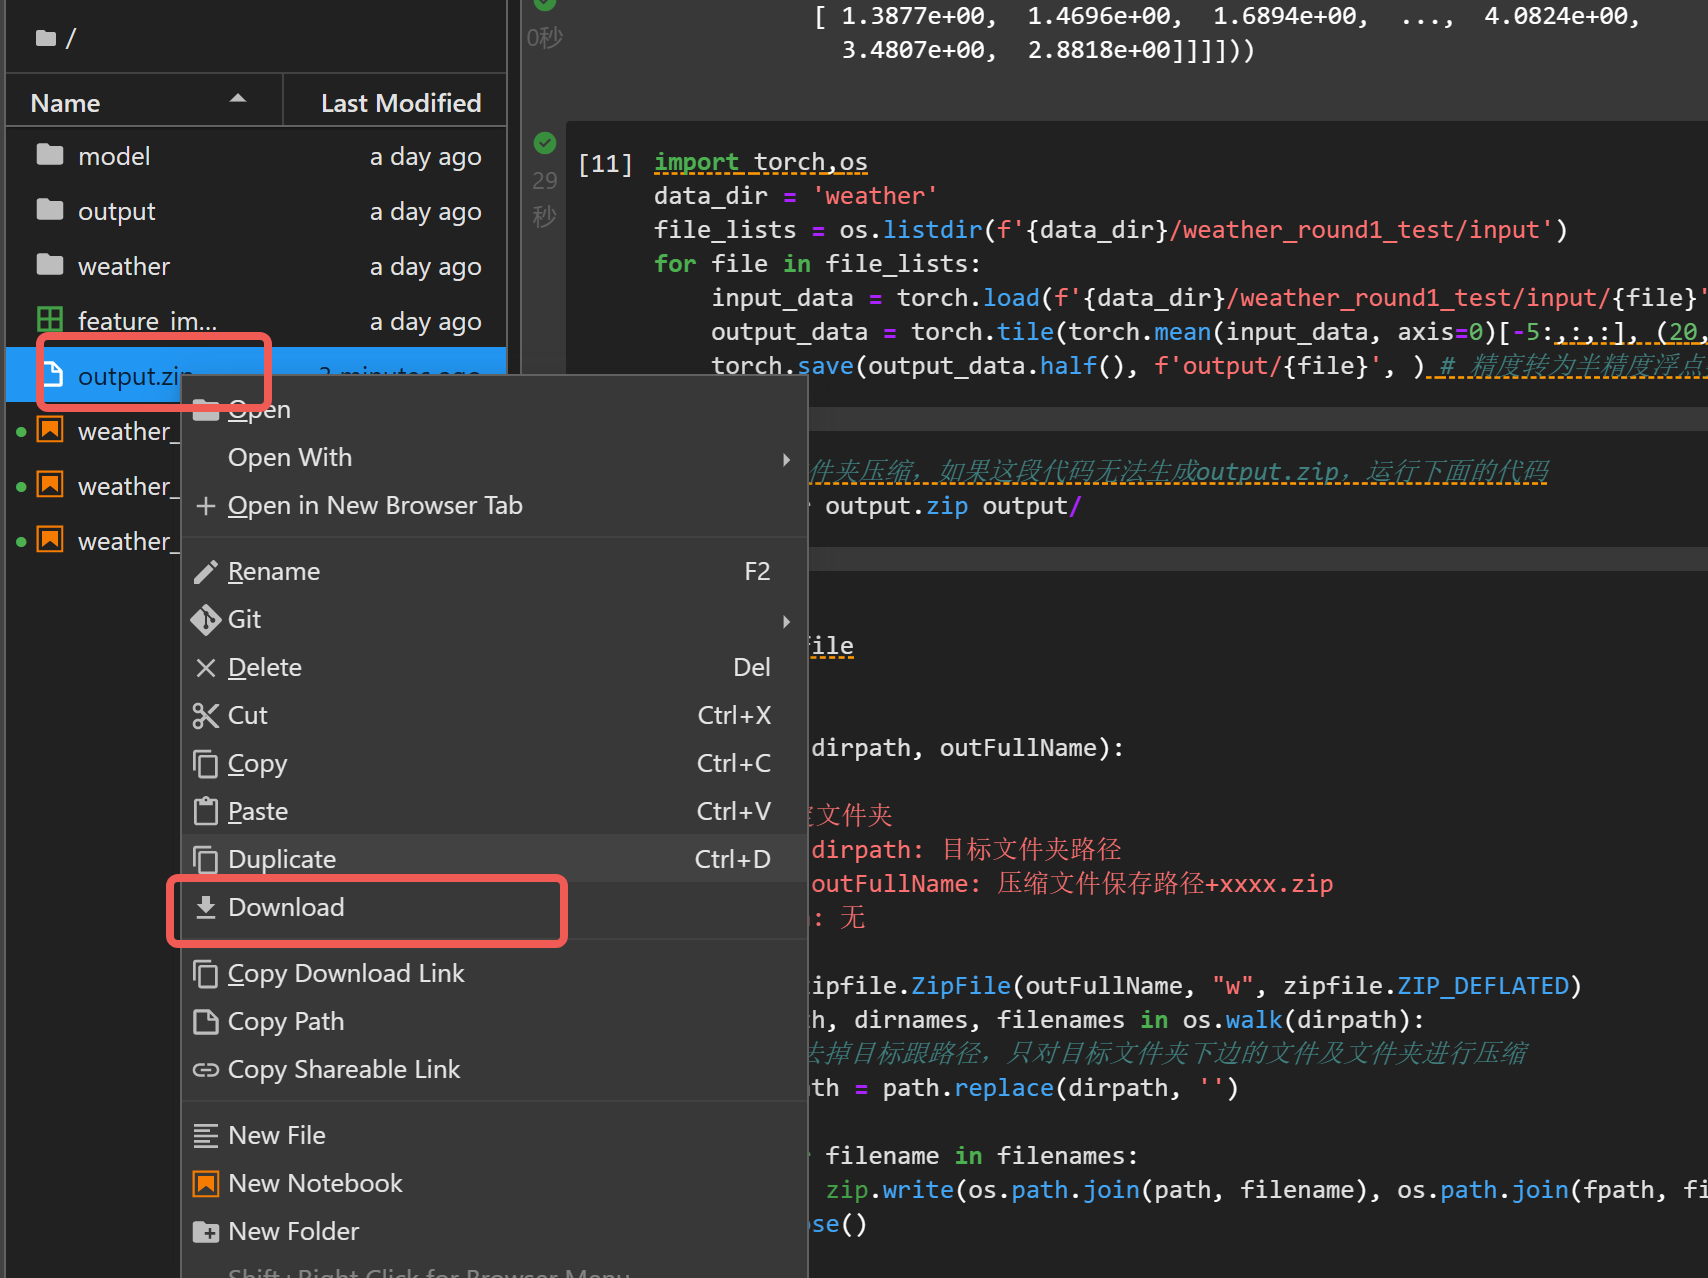

如果下载输出压缩包快完成时候，报网络错误：参考文档中的方法来解决：https://xqbbve5hpvs.feishu.cn/docx/DiooduxPHoCbv4xk5atc9Td5npe#BbDFdMvJboqFntxfI3TcxkZDnOe

## 提交结果
点击【提交结果】，上传刚下载的output.zip文件，稍等片刻评测成功
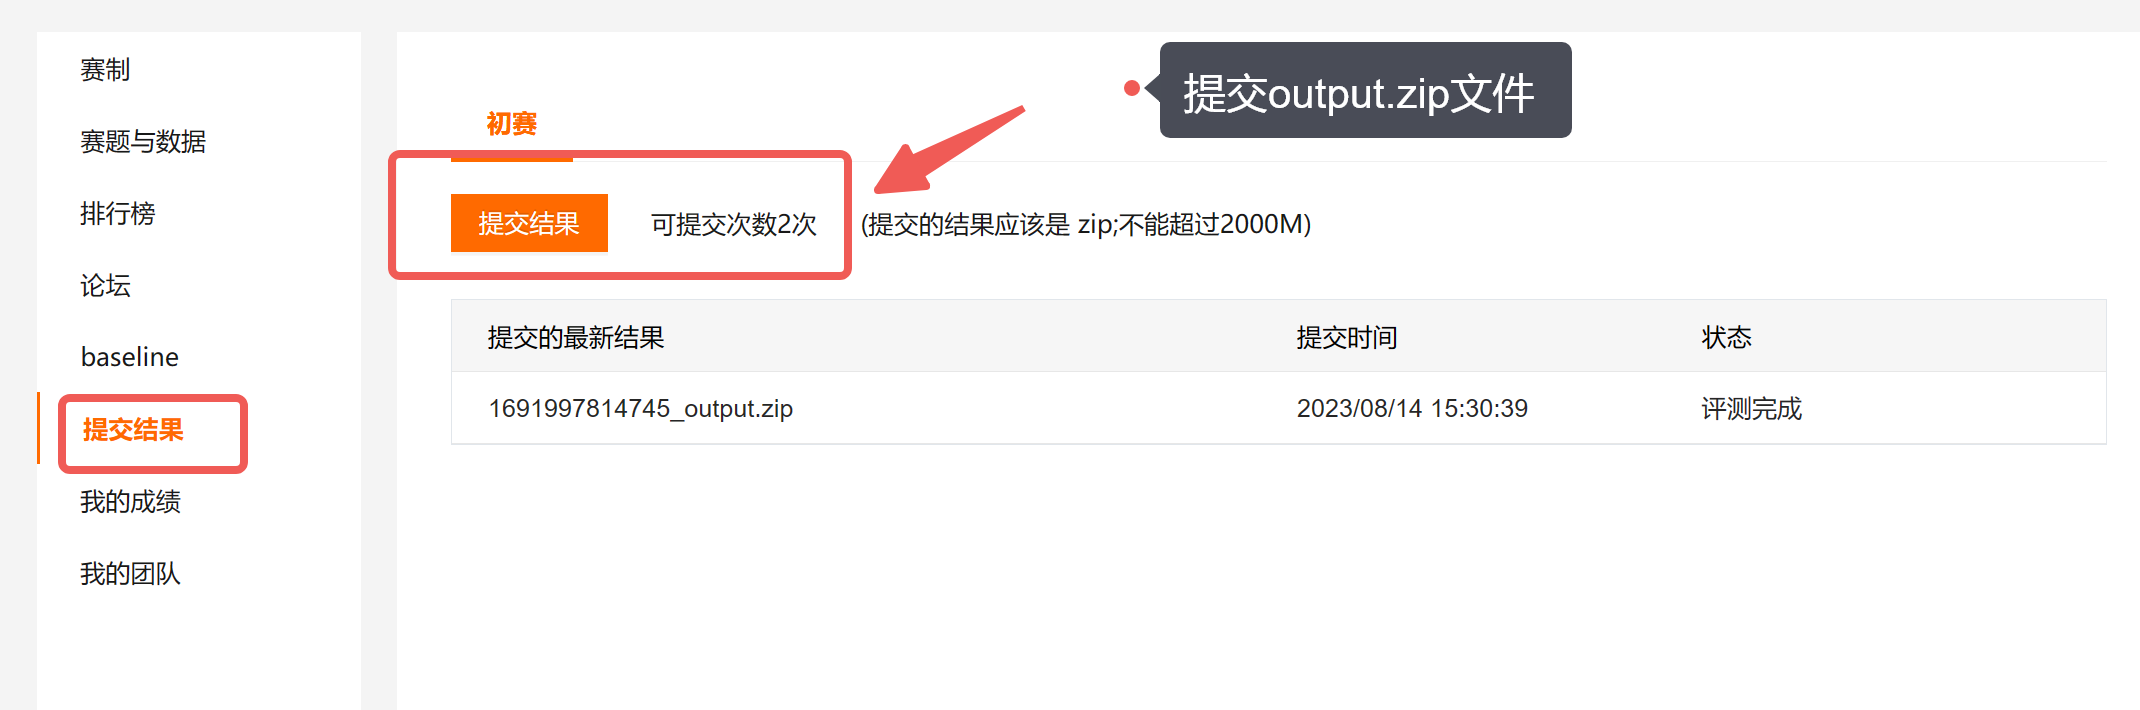

## 查看成绩
在【我的成绩】页面可以看到分数,排行榜里可以看到排名,开始迭代优化上分吧！
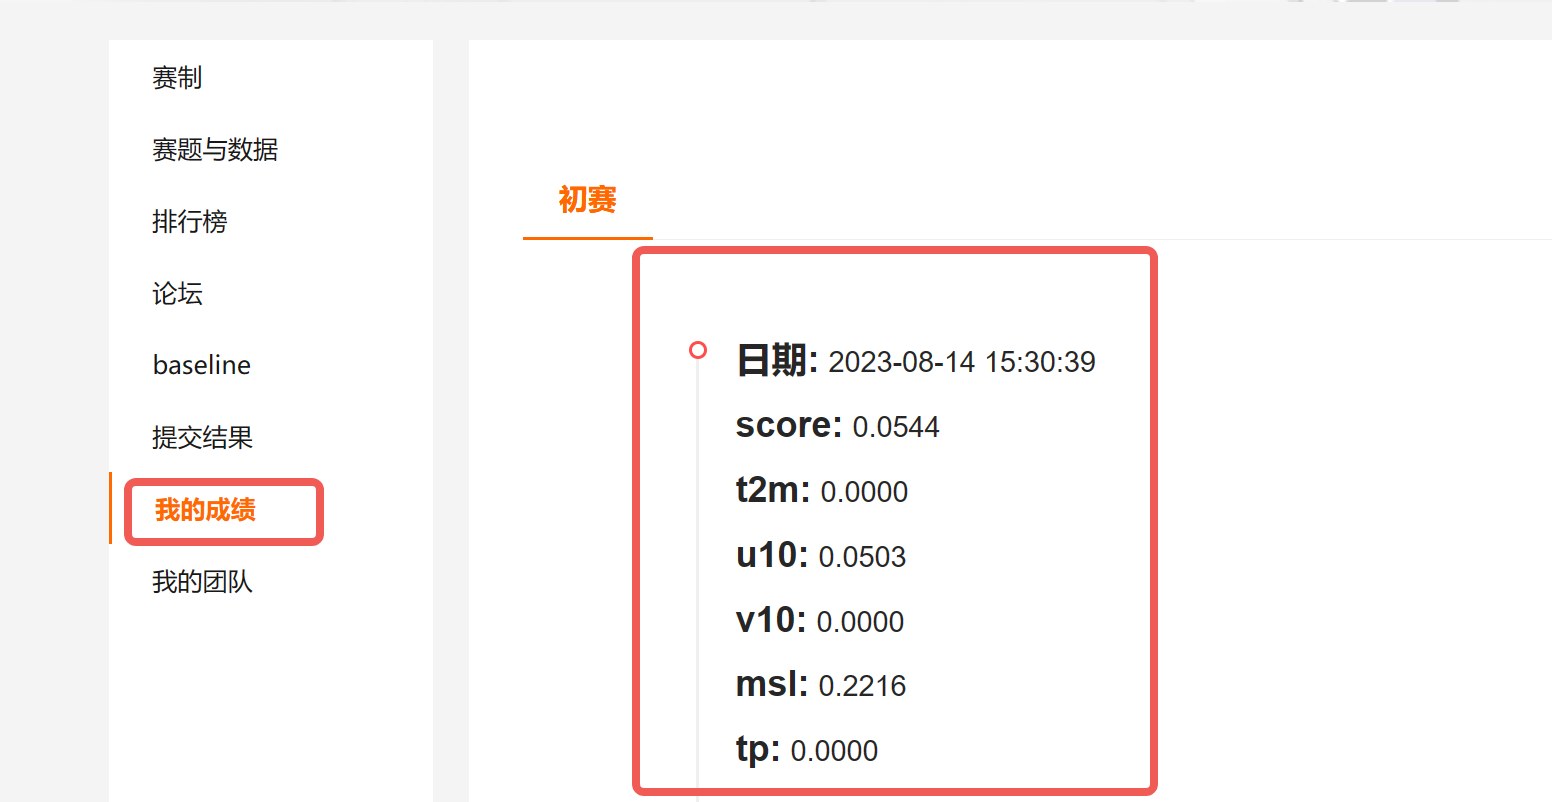

